In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

Below : plots the threshold for reconstruction in the cyclic SBM with r blocks and asymmetry eta. The "degree" s must be greater than the function depicted in the plots.  This threshold is 
$$ (\eta, r ) \mapsto \max_k \frac{1/2+c_1\sqrt{\eta(1-\eta)}}{(1/2+c_k \sqrt{\eta(1-\eta)})^2}$$
where $c_k = \cos( k \pi /(r+1))$, here $1 \leq k \leq r$.

In [12]:
def thresh(eta, r):
    """
    Returns the threshold above, for r blocks and for an array of asymmetry             parameter eta
    """
    theta = 2*np.sqrt(eta * (1-eta))
    c = [np.cos((1+k)*np.pi/(r+1)) for k in range(r)] #the cosines
    tab = []
    for k in range(r):
        tab.append((0.5 + c[0]  * theta) / ((0.5 + c[k] * theta)**2))
    tab = np.array(tab)
    return np.amax(tab, axis=0)


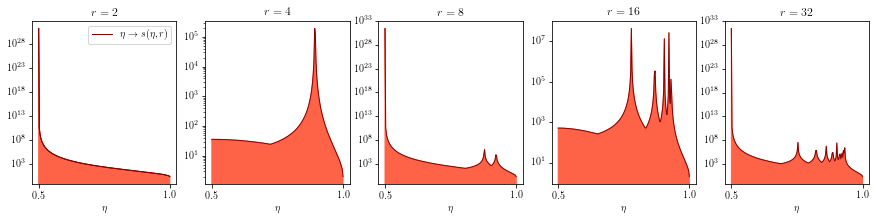

In [35]:
nr = 5
eta = np.linspace(0.5, 1, 200)
results  = []
for r in range(nr):
    results.append(thresh(eta, 2**(r+1)))

fig, ax = plt.subplots(ncols=nr, figsize=(15, 3))
bound=100

for i in range(nr):
    ax[i].set_yscale('log')

    #ax[i].set_ylim(0, bound)
    if i==0:
        ax[i].plot(eta, results[i], color='darkred', linewidth=1, label = r'$\eta \to s(\eta, r)$')
        ax[i].legend(loc=0)
    ax[i].plot(eta, results[i], color='darkred', linewidth=1)
    ax[i].fill_between(eta, results[i], 0, color='tomato')
    ax[i].set_title(r'$r = {}$'.format(2**(i+1)))
    
    ax[i].set_xticks([0.5, 1])


    

In [2]:
def eigvals(s, eta, r):
    """returns the eigenvalues of F"""
    eig = [s/2 + s * np.cos(np.pi * (i+1) / (r+1)) * 2 * np.sqrt(eta * (1-eta)) for i in range(r) ]
    return eig

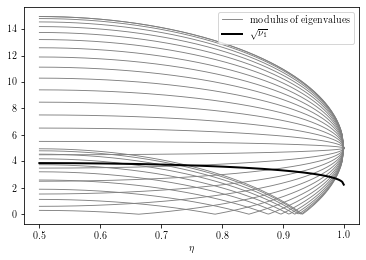

In [26]:
s=10
r=30
eigenvalues = [eigvals(s, e, r) for e in eta]
eigenvalues = np.array(eigenvalues)
limit = np.sqrt(eigenvalues[:,0])


fig, ax = plt.subplots()
for i in range(r):
    if i==0:
        ax.plot(eta, np.abs(eigenvalues[:,i]), linewidth=0.9, color='0.5', label='modulus of eigenvalues')
    ax.plot(eta, np.abs(eigenvalues[:,i]), linewidth=0.9, color='0.5')
ax.plot(eta, limit, linewidth=2, color='k', label=r'$\sqrt{\nu_1}$')
ax.legend(loc=0)
ax.set_xlabel(r'$\eta$')

plt.savefig("fig_eigenvalues.pdf", bbox_inches = 'tight', pad_inches = 0)


In [8]:
def etamin(s):
    """
    Returns the minimum asymmetry parameter eta for which 2-block reconstruction is feasible for a certain s
    """
    x = 1 + 2*( 1 - np.sqrt(2 * s + 1) )/s
    return 1/2 + np.sqrt(1 - x**2) / 2

In [10]:
etamin(10)

0.9794883558489202

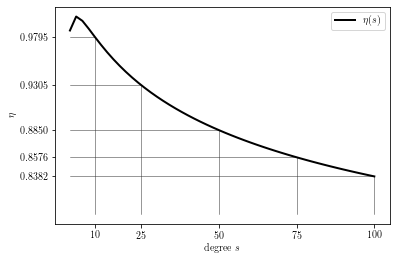

In [11]:
slist = np.linspace(2,100, 50)
absc = [10, 25, 50, 75, 100]

fig, ax = plt.subplots()
for a in absc:
    b = etamin(a)
    ax.plot((a, a), (0.8, b), linewidth=0.5, c='0.2')
    ax.plot((2, a), (b, b), linewidth=0.5, c='0.2')

ax.plot(slist, etamin(slist), linewidth=2, color='k', label=r'$\eta(s)$')
ax.legend(loc=0)
ax.set_xlabel(r'degree $s$')
ax.set_ylabel(r'$\eta$')
ax.set_xticks(absc)
ax.set_yticks(list(etamin(np.array(absc))))

plt.savefig("eta_s.pdf", bbox_inches = 'tight', pad_inches = 0)

# Computing the overlaps
The formula are
$$\sqrt{ \frac{1}{\langle \mathbf{1}, (I - \nu_i^{-2}\Pi)^{-1}f_i^2\rangle}}, \qquad \qquad b'_i = \sqrt{\frac{ 1}{\langle \mathbf{1}, (I - \nu_i^{-2}\Pi)^{-1}g_i^2\rangle}}$$
Note that the right unit eigenectors $f_i$ are simply $(\sqrt{\eta}, \pm \sqrt{1-\eta})$, while the corresponding left eigenvectors are $(1/2\sqrt{\eta}, 1/2\sqrt{1-\eta})$. 

In [4]:
#first we build the eigenvalues and eigenvectors
def Pi(s, eta):
    """
    Returns the eigenvalues nu1, nu2 of the matrix [[s/2, s*eta], [s*(1-eta), s/2]].
    Returns the associated left and right eigenvectors f1,f2, g1, g2. 
    The fi have unit norm. 
    """
    t = np.sqrt(eta * (1 - eta))
    nu1, nu2 = s * (0.5 + t), s * (0.5 - t) #eigenvalues

    f1 = np.array([np.sqrt(eta), np.sqrt(1 - eta)])
    f2 = np.array([np.sqrt(eta), - np.sqrt(1 - eta)])
    g1 = 0.5 * np.array([ 1 / np.sqrt(eta), 1 / np.sqrt(1 - eta)])
    g2 = 0.5 * np.array([ 1 / np.sqrt(eta),  -1 / np.sqrt(1 - eta)])

    return [nu1, nu2], [f1, f2], [g1, g2]

def testpi(s = 10, eta = 0.8):
    """ Both outputs should coincide"""
    nu, f, g = Pi(s, eta)
    P = np.zeros((2,2))
    for i in range(2):
        P += nu[i] * f[i].reshape(2,1) @ g[i].reshape(1,2)
    PI = np.array([[s/2, s*eta], [s*(1-eta), s/2]])
    return PI, P

testpi(2, 0.6)


(array([[1. , 1.2],
        [0.8, 1. ]]),
 array([[1. , 1.2],
        [0.8, 1. ]]))

In [11]:
def overlaps(s, eta):
    """returns ai as above"""

    nu, f, g = Pi(s,eta)
    u = np.array([1,1])

    a, b = [0,0], [0,0]

    theta = 2 * np.sqrt( eta * (1 - eta ) )

    for i in range(2): #computation of the ai
        for k in range(2):
            x = ( f[k] @ u ) * ( g[k] @ ( f[i]**2 ) )
            y = (1 - ( nu[k] / (nu[i]**2) ) )
            a[i] += x / y

    for i in range(2): #computation of the b'i
        for k in range(2):
            x = ( g[k] @ u ) * ( f[k] @ ( g[i]**2 ) )
            y = (1 - ( nu[k] / (nu[i]**2) ) )
            b[i] += x / y

    return a, b




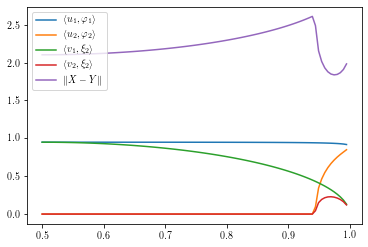

In [10]:
eta = np.linspace(0.5, 1, 100)

s=10
res1 = []
res2 = []
res3 = []
res4  =[]
for e in eta:
    a, b = overlaps(s, e)
    res1.append( 1 / np.sqrt(a[0]) )
    res3.append( 1 / np.sqrt(b[0]) )

    if e <= etamin(s):
        res2.append(0)
        res4.append(0)
    else:
        res2.append( 1 / np.sqrt(a[1]) )
        res4.append( 1 / np.sqrt(b[1]) )

plt.plot(eta, res1, label = r'$\langle u_1, \varphi_1 \rangle$')
plt.plot(eta, res2, label = r'$\langle u_2, \varphi_2 \rangle$')
plt.plot(eta, res3, label = r'$\langle v_1, \xi_2 \rangle$')
plt.plot(eta, res4, label = r'$\langle v_2, \xi_2 \rangle$')

plt.plot(eta, ( 4 - np.array(res1) - np.array(res2) - np.array(res3) - np.array(res4)), label = r'$\Vert X - Y \Vert$')

plt.legend(loc=2)

